In [1]:
from os import getcwd, path, listdir, path
from pathlib import Path
from matplotlib.pyplot import axis, imshow, show, figure, title, subplot, plot, legend
from keras import layers, losses, optimizers, preprocessing, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import data, image
from numpy import argmax, concatenate

# Constants

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
SEED = 123
DS_PATH = path.join(Path(getcwd()).parents[0], 'dataset')
ALL_PATH = path.join(DS_PATH, 'all_data')
TRAIN_PATH = path.join(DS_PATH, 'train')
VALID_PATH = path.join(DS_PATH, 'valid')
CATEGORIES = sorted([ dir_name for dir_name in listdir(ALL_PATH) if path.isdir(path.join(ALL_PATH, dir_name)) ]) # DS_PATH

# Import dataset

In [3]:
def file_count(dir_name: str) -> int:
    return len(concatenate([i for _, i in dir_name], axis=0))

In [4]:
train_ds, valid_ds = preprocessing.image_dataset_from_directory(ALL_PATH,
                                                            #color_mode='grayscale',
                                                            subset='both',
                                                            label_mode='categorical',
                                                            validation_split=VALIDATION_SPLIT,
                                                            seed=SEED,
                                                            image_size=(IMG_SIZE, IMG_SIZE),
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True
                                                            )

count = (2 * data.experimental.cardinality(valid_ds)) // 5
test_ds = valid_ds.take(count)
valid_ds = valid_ds.skip(count)

print("Using", file_count(test_ds), "files for testing and", file_count(valid_ds), "files for validation.")

Found 1658 files belonging to 5 classes.
Using 1327 files for training.
Using 331 files for validation.
Using 128 files for testing and 203 files for validation.


# Dataset visualization

In [5]:
data_augmentation = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.1),
    # layers.RandomZoom(-0.1),
    # layers.RandomTranslation(0.1, 0.1)
    ])

def preprocess(img, label):
    return data_augmentation(image.per_image_standardization(img)), label

train_ds = train_ds.map(preprocess, num_parallel_calls=data.AUTOTUNE)
valid_ds = valid_ds.map(preprocess, num_parallel_calls=data.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=data.AUTOTUNE)

21 total batches
(64, 224, 224, 3) (64, 5)


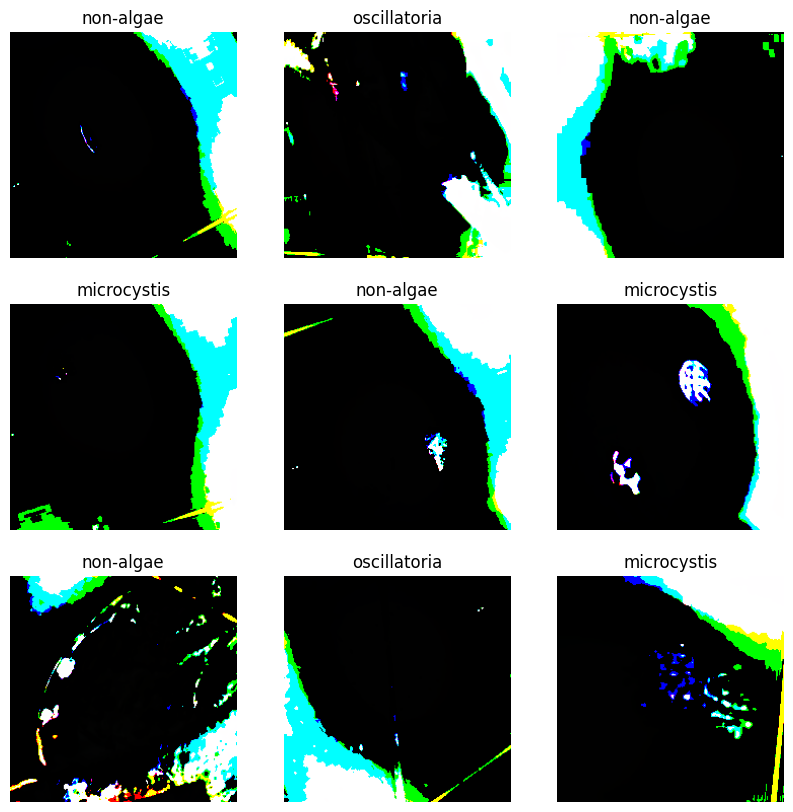

In [6]:
print(len(train_ds), 'total batches')

figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)
    for i in range(9):
        ax = subplot(3, 3, i + 1)
        imshow(images[i].numpy().astype("uint8"))
        title(CATEGORIES[labels[i].numpy().argmax()])
        axis("off")

# Build and compile model

In [7]:
# Prefetching samples in GPU memory helps maximize GPU utilization
train_ds = train_ds.prefetch(data.AUTOTUNE).cache()
valid_ds = valid_ds.prefetch(data.AUTOTUNE).cache()
test_ds = test_ds.prefetch(data.AUTOTUNE).cache()

model = Sequential([
  layers.Input(shape=(images.shape[1:])),# batch_size=images.shape[0]),

  layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu'),
  layers.MaxPooling2D(pool_size=3, strides=2),
  layers.BatchNormalization(momentum=0.9),

  layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=3, strides=1),
  layers.BatchNormalization(momentum=0.9),

  layers.Conv2D(filters=128, kernel_size=5, padding='same', strides=2, activation='relu'),
  layers.MaxPooling2D(pool_size=3, strides=1),
  layers.BatchNormalization(momentum=0.9),

  layers.Flatten(),

  layers.Dense(1024, activation='relu'),# input_shape=(prod(image_batch.shape[1:]),)),
  layers.BatchNormalization(momentum=0.9),

  layers.Dense(1024, activation='relu'),
  layers.BatchNormalization(momentum=0.9),
    
  layers.Dense(len(CATEGORIES), activation='softmax')
])

In [8]:
def compile(model) -> None:
    model.compile(optimizer=optimizers.Adam(learning_rate=3e-4),
              loss=losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

    model.summary()

compile(model)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 110, 110, 64)      │      4,864 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 54, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 54, 54, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)        │    102,464 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 128)       │    204,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 11, 11, 128)       │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 15488)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1024)              │ 15,860,736 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_3           │ (None, 1024)              │      4,096 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 1024)              │  1,049,600 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_4           │ (None, 1024)              │      4,096 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 5)                 │      5,125 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 17,236,933 (65.75 MB)

 Trainable params: 17,232,325 (65.74 MB)

 Non-trainable params: 4,608 (18.00 KB)

# Train model

In [9]:

EPOCHS = 5
VALIDATION_STEPS = 5
VERBOSE = 1
MONITOR = 'val_accuracy'
MODE = 'max'

def spe(dataset) -> int:
    return file_count(dataset) // BATCH_SIZE

EARLY = EarlyStopping(monitor=MONITOR,
                      patience=20,
                      verbose=VERBOSE,
                      mode=MODE,
                      restore_best_weights=True
                      )

def checkpoint(name: str) -> ModelCheckpoint:
    return ModelCheckpoint(name,
                           monitor=MONITOR,
                           verbose=VERBOSE,
                           save_best_only=True,
                           mode=MODE
                           )

def fit(model, filename: str):
    return model.fit(train_ds.repeat(),
                     validation_data=valid_ds.repeat(),
                     epochs=EPOCHS,
                     verbose=VERBOSE,
                     shuffle=True,
                     steps_per_epoch=spe(train_ds),
                     validation_steps=spe(valid_ds),
                     callbacks=[checkpoint(filename),EARLY]
                     )

history = fit(model, "model.keras")

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3131 - loss: 2.4381
Epoch 1: val_accuracy improved from -inf to 0.53646, saving model to model_1.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.3169 - loss: 2.4181 - val_accuracy: 0.5365 - val_loss: 2.9236
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5629 - loss: 1.3090
Epoch 2: val_accuracy improved from 0.53646 to 0.56835, saving model to model_1.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.5649 - loss: 1.3006 - val_accuracy: 0.5683 - val_loss: 2.0791
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7303 - loss: 0.8428
Epoch 3: val_accuracy did not improve from 0.56835
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.7304 - loss: 0.8395 - val_accuracy: 0.4820 - val_loss: 1.9901
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8059 - loss: 0.6239
Epoch 4: val_accuracy did not improve from 0.56835
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/st

# Evaluate accuracy

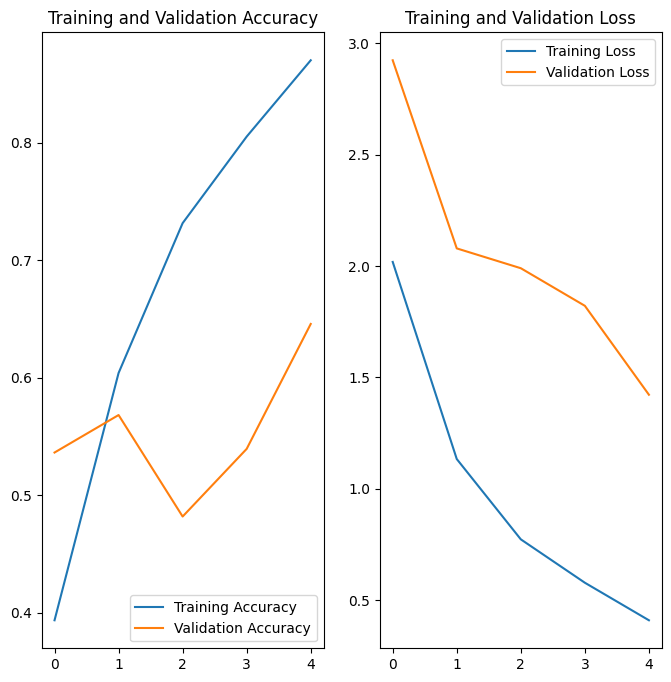

In [10]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
figure(figsize=(8, 8))
subplot(1, 2, 1)
plot(acc, label='Training Accuracy')
plot(val_acc, label='Validation Accuracy')
legend(loc='lower right')
title('Training and Validation Accuracy')

loss, val_loss = history.history['loss'], history.history['val_loss']
subplot(1, 2, 2)
plot(loss, label='Training Loss')
plot(val_loss, label='Validation Loss')
legend(loc='upper right')
title('Training and Validation Loss')
show()

# Testing and predicting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6667 - loss: 1.0720 
77.78% of predictions are correct


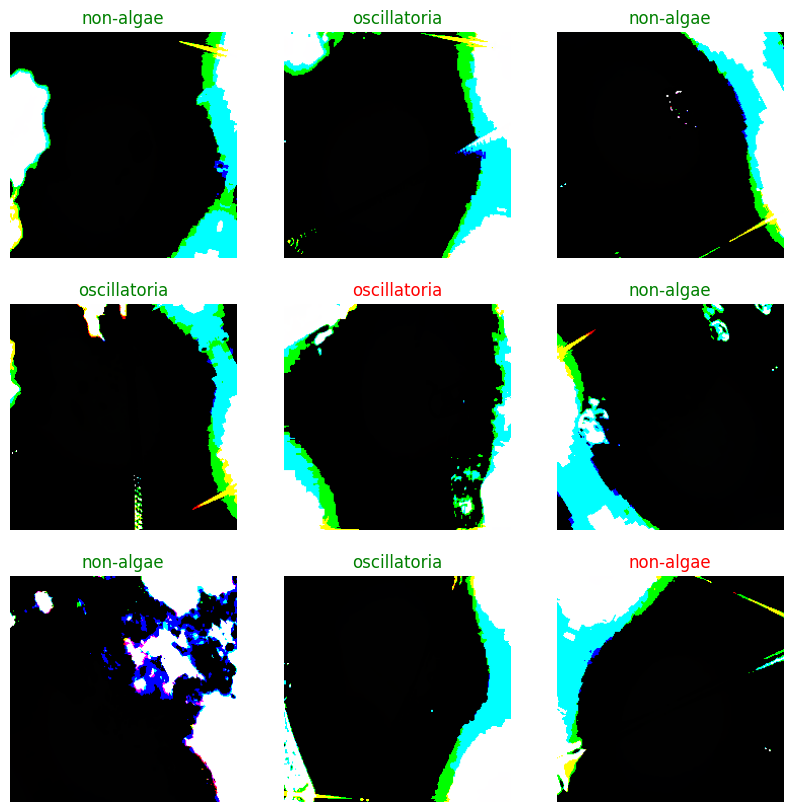

In [11]:
model.evaluate(test_ds, verbose = 1)
probability_model = Sequential([model, layers.Softmax()])
prediction = probability_model.predict(test_ds, verbose = 0)
counter = 0

figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        predict = CATEGORIES[argmax(prediction[i])]
        correct = CATEGORIES[argmax(labels[i].numpy())]
        img = images[i].numpy().astype("uint8")

        ax = subplot(3, 3, i + 1)
        axis("off")
        imshow(img)

        if predict == correct:
            color = 'green'
            counter += 1
        else: color = 'red'

        title(predict, fontdict={'color': color})

print(f"{counter / 9 * 100:.2f}% of predictions are correct")